In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys

N_up = 2
nb_dir = '/'.join(os.getcwd().split('/')[:-N_up])
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
N_up = 1
nb_dir = '/'.join(os.getcwd().split('/')[:-N_up])
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Step #0: Define Experimental Setup

In [7]:
from pathlib import Path

# general
device = "cuda:0"
model_name = "resnet18"
dataset = "MNIST"
train_batch_size = 512
laplace_batch_size = 128
test_batch_size = 512
n_test_data = None
rotations = [0, 30, 60, 90, 120, 150, 180]
n_out = 10
loss = "cross_entropy"

# paths
data_dir = "./data"
root_dir = Path(f"./{model_name}_{dataset}")
ggn_dir = root_dir / "ggn.pt"

# subnetwork selection
n_weights_subnet = 10000
subnet_selection = "random" # "magnitude", "min-wass"

# prediction
pred_lambda = 42.

# Step #1: Train or Load Model

In [8]:
from src.scripts.train_classification import train_loop
from src.utils import list_batchnorm_layers, get_n_params, model_to_device, instantiate_model

model = model_to_device(instantiate_model(model_name, dataset, 0.1), device)
bn_layers = list_batchnorm_layers(model)
print('Nparams:', get_n_params(model, bn_layers))

gpu = 0
train_loop(model, dname=dataset, data_dir=data_dir, epochs=73, workers=4, gpu=gpu, resume=str(root_dir / 'model_best.pth.tar'),
            weight_decay=1e-4, save_dir=str(root_dir), milestones=[40, 70], MC_samples=1, batch_size=train_batch_size)

Nparams: 31456
Use GPU: 0 for training
=> loading checkpoint '/scratch/subnet_inference/lenet_EMNIST/model_best.pth.tar'
=> loaded checkpoint '/scratch/subnet_inference/lenet_EMNIST/model_best.pth.tar' (epoch 73)
=> found progress file at '/scratch/subnet_inference/lenet_EMNIST/stats_array.pkl'
=> Loaded progress file at '/scratch/subnet_inference/lenet_EMNIST/stats_array.pkl'
Ntrain: 112800, Nval: 18800


# Step #2: Select Subnetwork

In [9]:
from src.datasets.image_loaders import get_image_loader
from src.utils import print_nonzeros
from src.masking.masking import random_mask, smallest_magnitude_mask, wasserstein_mask

# compute subnetwork mask
if n_weights_subnet == None:
    mask = None

elif subnet_selection == "random":
    mask, index_mask = random_mask(model, bn_layers, n_weights_subnet, device=device)

elif subnet_selection == "min-wass":
    train_loader = get_image_loader(dataset, batch_size=train_batch_size, cuda=True, workers=4, distributed=False, data_dir=data_dir)[1]
    mask, index_mask = wasserstein_mask(model, bn_layers, n_weights_subnet, train_loader, device)

elif subnet_selection == "magnitude":
    mask, index_mask = smallest_magnitude_mask(model, bn_layers, n_weights_subnet)
    
else:
    raise NotImplementedError("Supported subnetwork selection methods: random, min-wass, magnitude.")

if mask is not None:
    # print mask information
    print_nonzeros(mask)

conv1.conv.weight                   | remaining =     213 /     800 ( 26.62%) | pruned =     587 | shape = torch.Size([32, 1, 5, 5])
conv2.conv.weight                   | remaining =    1176 /    9216 ( 12.76%) | pruned =    8040 | shape = torch.Size([32, 32, 3, 3])
conv3.conv.weight                   | remaining =    1042 /   18432 (  5.65%) | pruned =   17390 | shape = torch.Size([64, 32, 3, 3])
fc.weight                           | remaining =    2531 /    3008 ( 84.14%) | pruned =     477 | shape = torch.Size([47, 64])
remaining: 4962, pruned: 26494, total: 31456, compression rate:       6.34x  ( 84.23% pruned)


# Step #3: Do Linearized Laplace Inference

In [7]:
from src.laplace.laplace import Laplace
from src.datasets.image_loaders import get_image_loader

# instantiate Laplace model
laplace_dir = root_dir / f"laplace.pth.tar"
laplace_model = Laplace(model, mask=mask, index_mask=index_mask, save_path=laplace_dir, device=device, loss=loss, n_out=n_out)

# load or fit Hessian approximation
if ggn_dir.exists():
    print("Loading GGN from disk...")
    laplace_model.H = torch.load(ggn_dir)

elif laplace_dir.exists():
    print("Loading Laplace model from disk...")
    laplace_model.load()

else:
    print(f"Computing Hessian/GGN...")
    train_loader = get_image_loader(dataset, batch_size=laplace_batch_size, cuda=True, workers=4, distributed=False, data_dir=data_dir)[1]
    laplace_model.fit_laplace(train_loader)

Computing Fisher with 1 samples...
Ntrain: 112800, Nval: 18800


/scratch/ead54/miniconda3/envs/blt-env/lib/python3.7/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "



# Step #4: Make Predictions

In [10]:
import numpy as np

results_path = root_dir / "results.npy"
if results_path.exists():
    results_dict = np.load(results_path, allow_pickle=True).item()
else:
    results_dict = {}

In [11]:
import numpy as np

from src.evaluation.evaluate_laplace import evaluate_laplace
from src.evaluation.evaluate_baselines import evaluate_map

methods = ["MAP", "subnetwork_inference"]

# compute error, log-likelihood, Brier score and ECE on shifted test data
for method in methods:
    for rot in rotations:
        if method in results_dict and rot in results_dict[method]:
            continue
        elif method not in results_dict:
            results_dict[method] = {}

        print(f"Computing predictions for {method} at rotation={rot}...")
        
        if method == "MAP":
            results_dict[method][rot] = evaluate_map(model, dataset, data_dir, device, loss, corruption=None,
                                                    rotation=rot, batch_size=test_batch_size, n_test_data=n_test_data)
        else:
            results_dict[method][rot] = evaluate_laplace(laplace_model, dataset, data_dir, corruption=None, rotation=rot, 
                                                        batch_size=test_batch_size, λ=pred_lambda, n_test_data=n_test_data)

# save result dictionary
np.save(results_path, results_dict)

Computing predictions for SI_test at rotation=0...
Computing covariance matrix...



/var/home/ead54/Code/bayesian-lottery-tickets/src/evaluation/utils.py:49: RuntimeWarning: invalid value encountered in true_divide
  bin_probs = bin_corrects / bin_counts
/var/home/ead54/Code/bayesian-lottery-tickets/src/evaluation/utils.py:59: RuntimeWarning: Mean of empty slice.
  reference = np.array([expanded_preds[bin_idxs == nbin].mean() for nbin in range(n_bins)])
/scratch/ead54/miniconda3/envs/blt-env/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
Computing predictions for SI_test at rotation=30...
Computing covariance matrix...



Computing predictions for SI_test at rotation=60...
Computing covariance matrix...



Computing predictions for SI_test at rotation=90...
Computing covariance matrix...



Computing predictions for SI_test at rotation=120...
Computing covariance matrix...



Computing predictions for SI_test at rotation=150...
Computing covariance matrix...



Computing predictions for SI_test at rotation=180...
Computing covariance matrix...


# Step #5: Plot Results

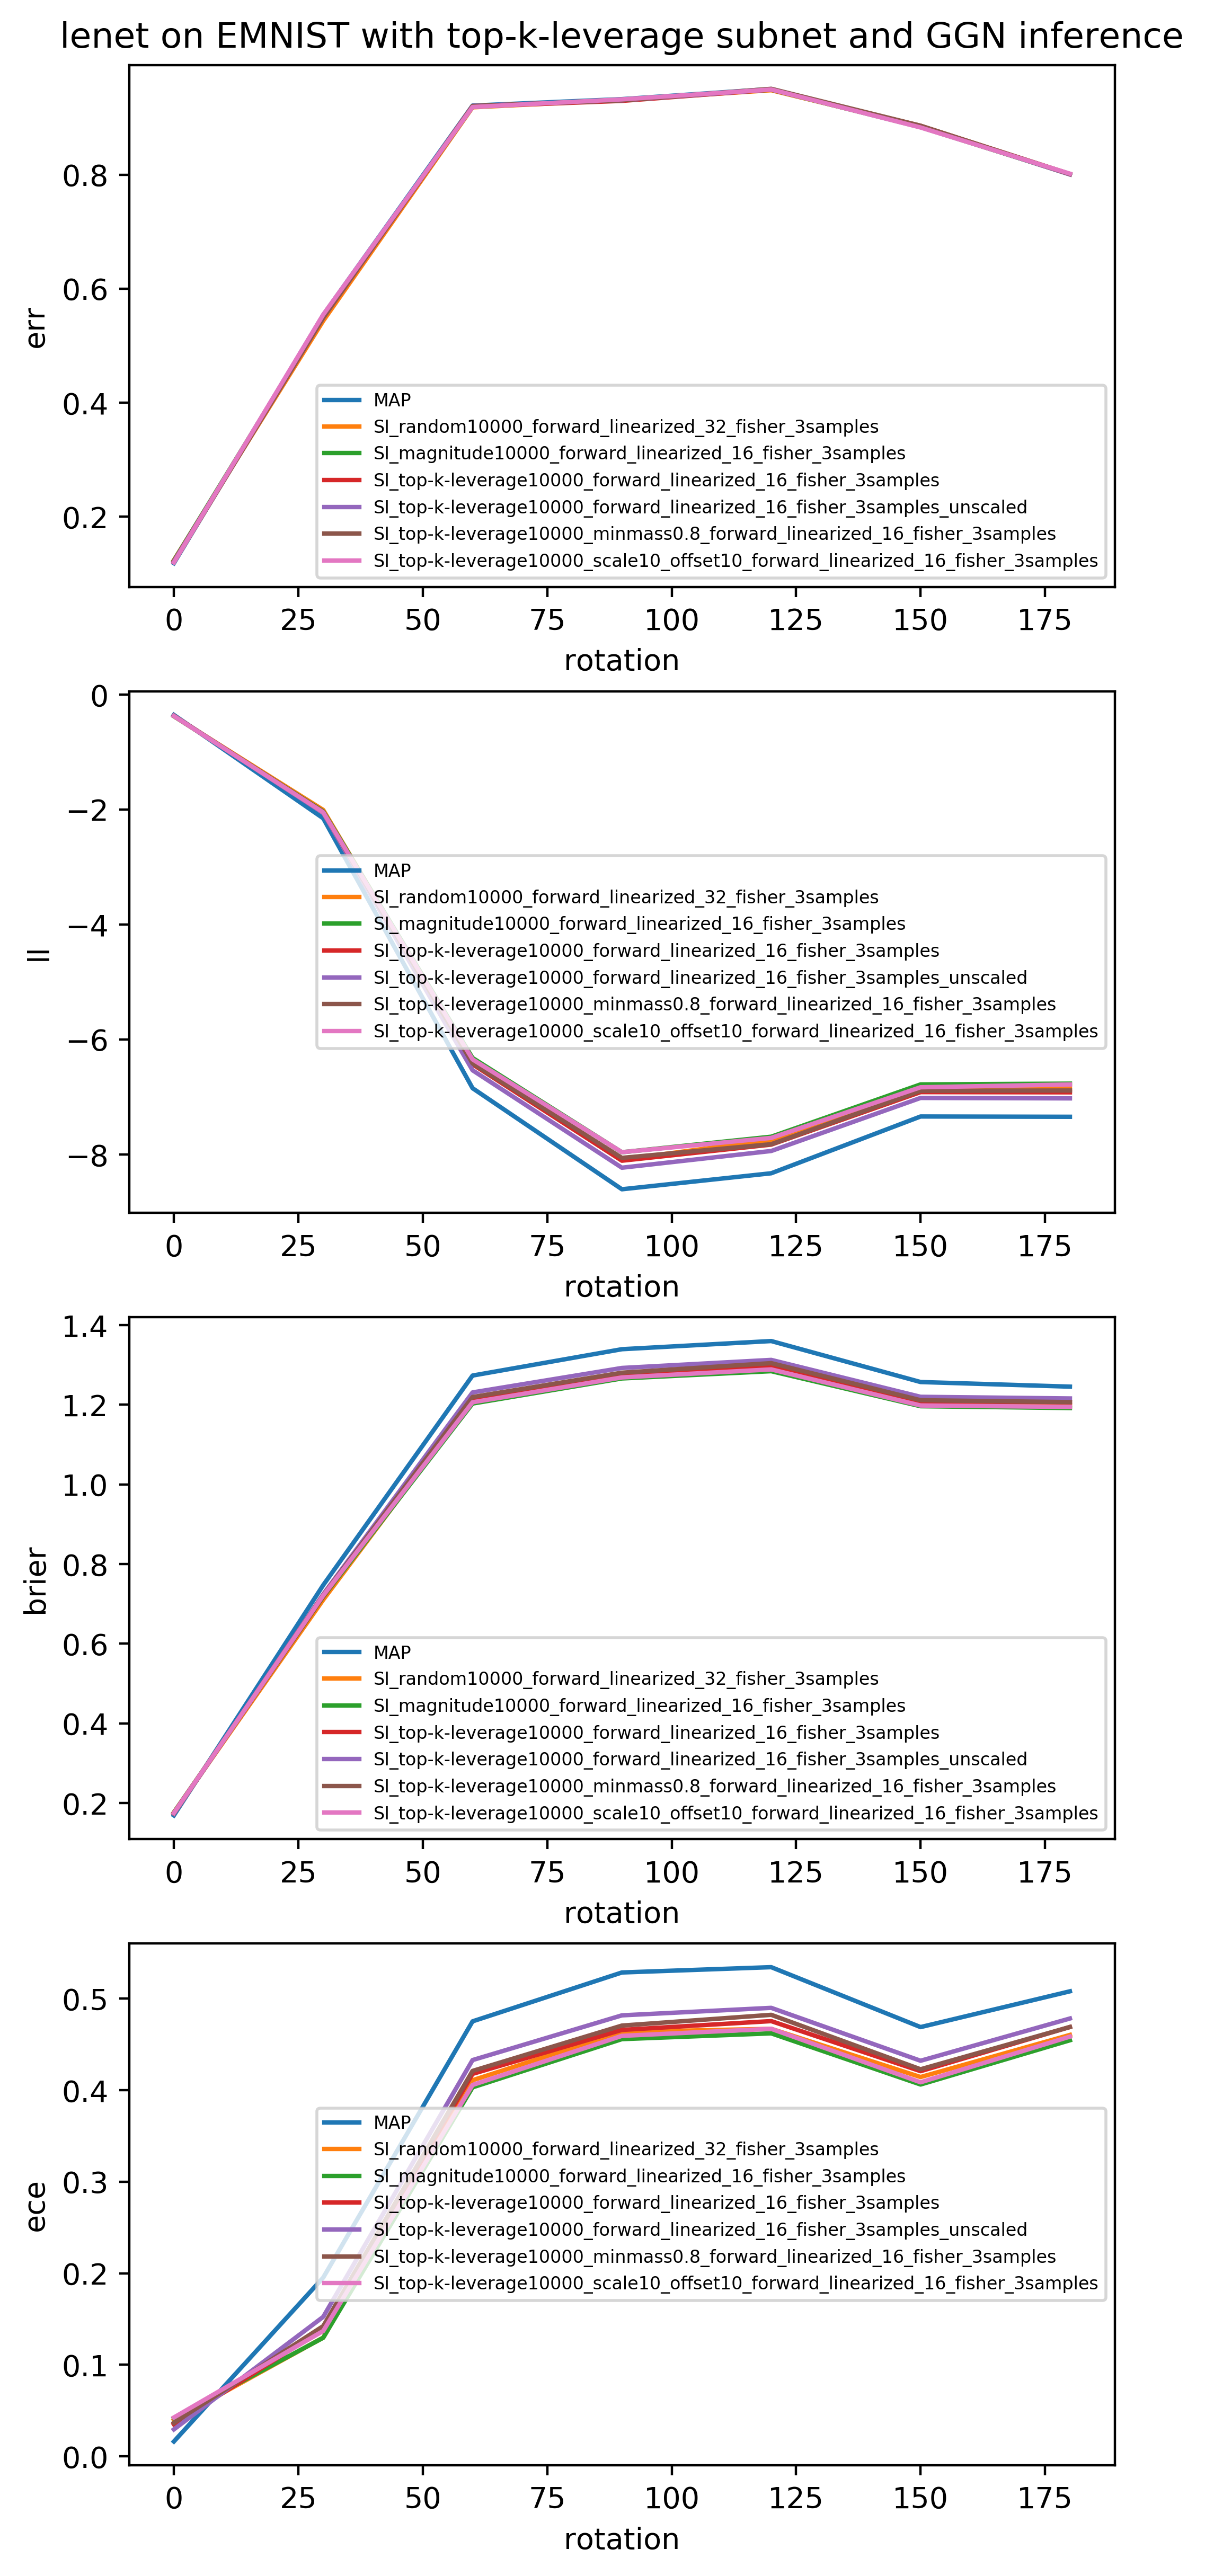

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

methods_to_plot = ["MAP", "subnetwork_inference"]

metrics = results_dict[methods_to_plot[0]][rotations[0]].keys()

fig, axes = plt.subplots(4, 1, figsize = (6, 15), dpi=400)
axes[0].set_title(f"{model_name} on {dataset} with {subnet_selection} subnetwork")

xs = list(results_dict[methods_to_plot[0]].keys())
for metric, axis in zip(metrics, axes):
    for method in methods_to_plot:
        ys = [results_dict[method][rot][metric] for rot in results_dict[method]]
        axis.plot(xs, ys, label=method)
    axis.set_ylabel(metric)
    axis.set_xlabel("rotation")
    axis.legend(prop={'size': 6})

plt.show()